In [1]:
import torch
import numpy as np
from torch import nn
import torch.optim as optim

from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import imageio

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])

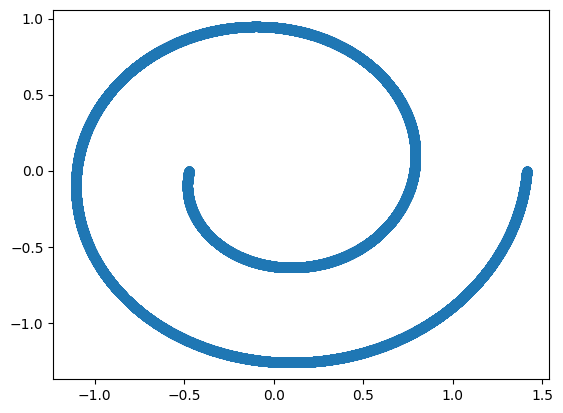

In [4]:
X = sample_batch(64_000)
plt.scatter(X[:, 0], X[:, 1])

In [5]:
#from annotated diffusion

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

Text(0.5, 1.0, 'sigmoid')

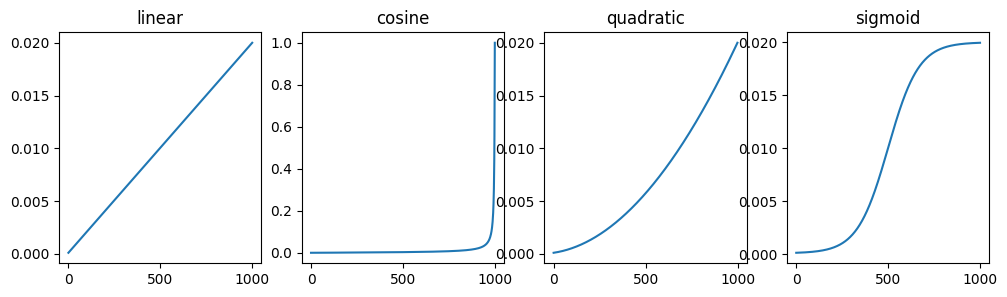

In [6]:
betas_cosine=cosine_beta_schedule(1000)
betas_linear=linear_beta_schedule(1000)
betas_quadratic=quadratic_beta_schedule(1000)
betas_sigmoid=sigmoid_beta_schedule(1000)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.plot(betas_linear)
plt.title('linear')

plt.subplot(1, 4, 2)
plt.plot(betas_cosine) 
plt.title('cosine')
 
plt.subplot(1, 4, 3)
plt.plot(betas_quadratic)
plt.title('quadratic')

plt.subplot(1, 4, 4)
plt.plot(betas_sigmoid)
plt.title('sigmoid')

In [7]:
class MyScheduler:
    def __init__(self, T=100, scheduler_type="linear", beta_start=1e-4, beta_end=0.02, device='cuda'):
        # self.betas=torch.linspace(beta_start, beta_end, T).to(device)
        if scheduler_type=="linear":
            betas=linear_beta_schedule(T)
        elif scheduler_type=="cosine":
            betas=cosine_beta_schedule(T)
        elif scheduler_type=="quadratic":
            betas=quadratic_beta_schedule(T)
        elif scheduler_type=="sigmoid":
            betas=sigmoid_beta_schedule(T) 
        self.betas = betas.to(device)
        
        self.T = T
        self.alphas=1.0 - self.betas
        self.device=device

        self.sqrt_one_minus_betas = torch.sqrt(1.0 - self.betas)
        
        self.alpha_bars = torch.cumprod(self.alphas, dim=0) 
        
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

        self.sqrt_betas = torch.sqrt(self.betas)
        self.sqrt_alphas = torch.sqrt(self.alphas)

    def extract(self, a, t, x_shape): 
        """
        collect the values at time t from a and reshape it to x_shape
        
        a: precomputed one dimensional values
        t: time steps (scalar or tensor)
        x_shape: shape of the tensor to be returned 
        """
        
        b=t.shape[0]
        out=a.gather(-1, t)
        rt=out.reshape(b, *((1,) * (len(x_shape) - 1)))  #batch, unpack([1]*rest of the dimension)
        return rt  

    def get_xt(self, x0, t):
        """
        compute noisy image xt from x0 at time t 
        """ 
        eps=torch.randn_like(x0)
        # xt=x0 * self.sqrt_alpha_bars[t] + self.sqrt_one_minus_alpha_bars[t] * eps
        xt = x0 * self.extract(self.sqrt_alpha_bars, t, x0.shape) + eps * self.extract(self.sqrt_one_minus_alpha_bars, t, x0.shape)
        return xt, eps

In [8]:
class MyDDPM:
    def __init__(self, scheduler, noise_predictor_net, device='cuda'): 
        self.scheduler=scheduler
        self.noise_predictor_net=noise_predictor_net
        self.device=device
    
    def forward(self, x0):
        """ 
        noise x0 at random time t
        return noise, predicted noise
        """
        B= x0.shape[0]
        t=torch.randint(low=0, high=self.scheduler.T, size=(B,)).long().to(self.device)
        xt, eps=self.scheduler.get_xt(x0, t)
        eps_pred=self.noise_predictor_net(xt, t)
        return xt, eps, eps_pred
    
    
    def x_t_minus_1_from_x_t(self, t, x_t, eps_theta): 
        """ 
        Algorithm 2 in the DDPM paper
        """
        sqrt_alpha=self.scheduler.extract(self.scheduler.sqrt_alphas, t, x_t.shape)
        sqrt_one_minus_alpha_bar=self.scheduler.extract(self.scheduler.sqrt_one_minus_alpha_bars, t, x_t.shape)
        beta=self.scheduler.extract(self.scheduler.betas, t, x_t.shape)
        x_t_minus_1 = (1 / sqrt_alpha) * (x_t - ( beta / sqrt_one_minus_alpha_bar ) * eps_theta)
        
        return x_t_minus_1
    
    def sample_ddpm(self, nsamples, sample_shape):
        """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
        with torch.no_grad():
            xt = torch.randn(size=(nsamples, *sample_shape)).to(self.device)   #start from random noise
            xts = [xt]
            for it in range(self.scheduler.T-1, 0, -1):
                t=torch.tensor([it]).repeat_interleave(nsamples, dim=0).long().to(self.device)
                eps_theta = self.noise_predictor_net(xt, t) 
                # See DDPM paper between equations 11 and 12
                xt = self.x_t_minus_1_from_x_t(t, xt, eps_theta) 
                if it > 1: # No noise for t=0
                    z = torch.randn(size=(nsamples, *sample_shape)).to(self.device)  
                    sqrt_beta=self.scheduler.extract(self.scheduler.sqrt_betas, t, x.shape)       #use fixed varience.
                    xt += sqrt_beta* z
                xts.append(xt)
            return xt, xts

In [9]:
x0= sample_batch(5_000)
x0 = torch.tensor(x0, dtype=torch.float32, device='cuda')

In [10]:
T=100
# ms=MyScheduler(T=T, beta_start=1e-4, beta_end=2e-2)

# ms=MyScheduler(T=T, scheduler_type="cosine" , beta_start=1e-4, beta_end=2e-2)
ms=MyScheduler(T=T, scheduler_type="sigmoid" , beta_start=1e-4, beta_end=2e-2)

In [11]:
ts=[]
xs=[]
for t in range(T)[::20]:
    t=torch.tensor([t]).long().to(device)
    if t==0:
        xt=x0
    else:
        xt,eps=ms.get_xt(x0, t)
    
    xt =xt.cpu().detach().numpy()
        
    ts.append(t.detach().cpu().numpy())
    xs.append(xt)

In [12]:
ts

[array([0]), array([20]), array([40]), array([60]), array([80])]

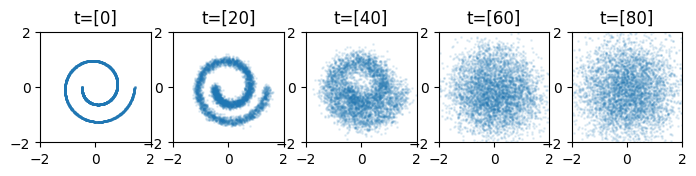

In [13]:
i=1
plt.figure(figsize=(10, 4))
for t,x in zip(ts, xs):
    plt.subplot(1, 6, i)
    i +=1
    
    plt.scatter(x[:, 0], x[:, 1], alpha=.1, s=1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')
    plt.title(f't={t}') 

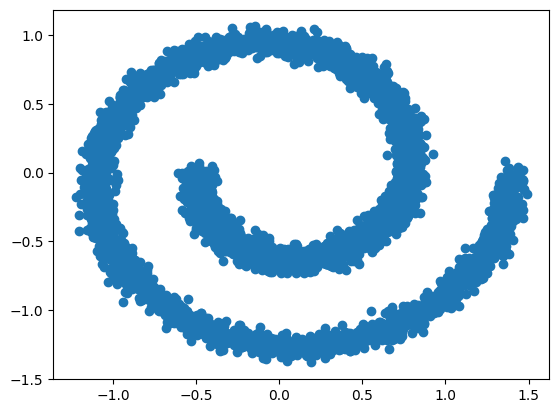

In [14]:
timestep = torch.as_tensor([10], dtype=torch.long).to(device)
xt , eps= ms.get_xt(x0, timestep) 
plt.scatter(xt[:, 0].cpu().numpy(), xt[:, 1].cpu().numpy())

In [15]:
class NoiseModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(NoiseModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)  #x, t
        self.midblocks = nn.ModuleList( [nn.Linear(nunits, nunits) for _ in range(nblocks)] )
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t.reshape(-1,1)])
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
            val = nn.functional.relu(val)
        val = self.outblock(val)
        return val

In [16]:
model = NoiseModel(nfeatures=2, nblocks=4)

device = "cuda"
model = model.to(device)

model

NoiseModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [17]:
ddpm=MyDDPM(ms, model)

In [18]:
nepochs = 1000 

batch_size = 2048

diffusion_steps = 100

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        Xbatch = torch.tensor(Xbatch, dtype=torch.float32 ).to(device)

        x_zeros = Xbatch
        B = x_zeros.shape[0] 
        t = torch.randint(low=0, high=ms.T, size=(B,)).long().to(ms.device)  
        xt, eps = ms.get_xt(x_zeros, t)

        pred_eps=model(xt, t.reshape(-1,1))
        loss = loss_fn(pred_eps, eps.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.9972999691963196
Epoch 1 loss = 0.9267493486404419
Epoch 2 loss = 0.7994253039360046
Epoch 3 loss = 0.7567309141159058
Epoch 4 loss = 0.7313258647918701
Epoch 5 loss = 0.7104502320289612
Epoch 6 loss = 0.7098138928413391
Epoch 7 loss = 0.7096732258796692
Epoch 8 loss = 0.7037833333015442
Epoch 9 loss = 0.7022669315338135
Epoch 10 loss = 0.6965802311897278
Epoch 11 loss = 0.6922630667686462
Epoch 12 loss = 0.6848856210708618
Epoch 13 loss = 0.6809937953948975
Epoch 14 loss = 0.6821651458740234
Epoch 15 loss = 0.6699351072311401
Epoch 16 loss = 0.6738625168800354
Epoch 17 loss = 0.6681276559829712
Epoch 18 loss = 0.6720497012138367
Epoch 19 loss = 0.6632276773452759
Epoch 20 loss = 0.6631196737289429
Epoch 21 loss = 0.656374454498291
Epoch 22 loss = 0.6584400534629822
Epoch 23 loss = 0.6535399556159973
Epoch 24 loss = 0.653121292591095
Epoch 25 loss = 0.6492847800254822
Epoch 26 loss = 0.6503398418426514
Epoch 27 loss = 0.6595161557197571
Epoch 28 loss = 0.63354521989822

In [19]:
tx,xts=ddpm.sample_ddpm(5000, (2,))
tx=tx.detach().cpu().numpy().squeeze()
tx.shape

(5000, 2)

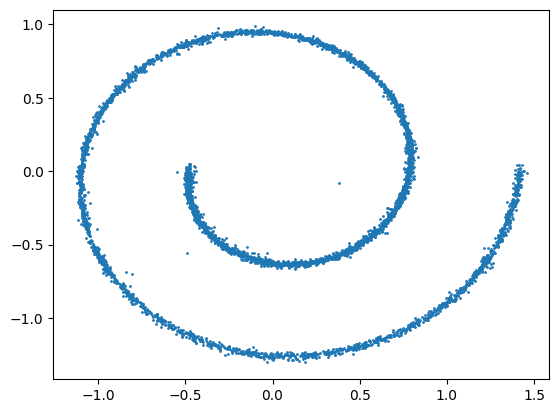

In [20]:
plt.scatter(tx[:, 0], tx[:, 1], s=1)

In [21]:
# plt.plot(tx[:, 0], tx[:, 1] )

In [22]:
len(xts)
xtss=[x.detach().cpu().numpy().squeeze() for x in xts]

In [23]:
len(xts), xts[0].shape, xts[1].shape

(100, torch.Size([5000, 2]), torch.Size([5000, 2]))

In [24]:
#generate images
# import imageio

# images=[]
# for x in xtss:
#     img = plt.scatter(x[:, 0], x[:, 1], s=1)
#     images.append(img)
# len(images)

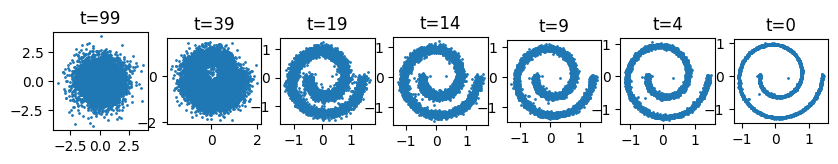

In [25]:
st=[0, 60,  80, 85, 90, 95, 99]

plt.figure(figsize=(10, 4))
for i in st:
    plt.subplot(1, len(st), st.index(i)+1)
    plt.scatter(xtss[i][:, 0], xtss[i][:, 1], s=1)
    plt.title(f"t={99-i}") 
    plt.gca().set_aspect('equal')

### creating gif

In [26]:
import numpy as np

def data_to_image(data, img_size=256, data_range=(-2.5, 2.5)):
    """
    Converts 500x2 data points into a 2D NumPy image.
    
    Args:
        data (np.ndarray): 500x2 array of points (x, y).
        img_size (int): Size of the output image (img_size x img_size).
        data_range (tuple): Range of data in both axes (-2.5, 2.5).

    Returns:
        np.ndarray: 2D binary image with points plotted.
    """
     
    image = np.zeros((img_size, img_size), dtype=np.uint8)

    scale = img_size / (data_range[1] - data_range[0])  # Scale factor
    offset = -data_range[0] * scale  # Offset to shift -2.5 -> 0
    
    x_pixels = (data[:, 0] * scale + offset).astype(int)
    y_pixels = (data[:, 1] * scale + offset).astype(int)

    x_pixels = np.clip(x_pixels, 0, img_size - 1)
    y_pixels = np.clip(y_pixels, 0, img_size - 1)

    image[y_pixels, x_pixels] = 255  #  white (255)

    return image


data = np.random.uniform(-2.5, 2.5, (500, 2))  # Example 500x2 data points
image = data_to_image(data)

print(image.shape)  # Output: (256, 256)


(256, 256)


In [27]:
images=[]
for x in xtss:
    img = data_to_image(x)
    images.append(img)

len(images)

100

In [28]:
imageio.mimsave('media/swiss_roll2.gif', images, fps=15)

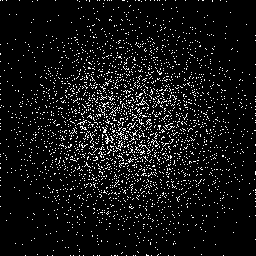

In [29]:
from IPython.display import Image
Image(filename='media/swiss_roll2.gif')

### sampling breakdown

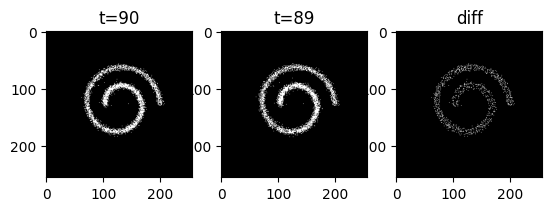

In [41]:
t=90
xt= images[t]
xt_1 = images[t-1]
dx=xt-xt_1

plt.subplot(1, 3, 1)
plt.imshow(xt, cmap='gray')
plt.title(f't={t}')
plt.subplot(1, 3, 2)
plt.imshow(xt_1, cmap='gray')
plt.title(f't={t-1}')
plt.subplot(1, 3, 3)
plt.imshow(dx, cmap='gray')
plt.title(f'diff')
plt.show()

In [42]:
tx,xts=ddpm.sample_ddpm(5000, (2,))
tx=tx.detach().cpu().numpy().squeeze()
tx.shape

(5000, 2)

In [43]:
nsamples=5000
sample_shape=(2,)
self=ddpm 

rows={}
with torch.no_grad():
    xt = torch.randn(size=(nsamples, *sample_shape)).to(self.device)   #start from random noise
    xts = [xt]
    for it in range(self.scheduler.T-1, 0, -1):
        t=torch.tensor([it]).repeat_interleave(nsamples, dim=0).long().to(self.device)
        eps_theta = self.noise_predictor_net(xt, t) 
        row=[xt, eps_theta]
        
        # See DDPM paper between equations 11 and 12
        xt = self.x_t_minus_1_from_x_t(t, xt, eps_theta) 
        if it > 1: # No noise for t=0
            z = torch.randn(size=(nsamples, *sample_shape)).to(self.device)  
            sqrt_beta=self.scheduler.extract(self.scheduler.sqrt_betas, t, x.shape)       #use fixed varience.
            xt += sqrt_beta* z
        xts.append(xt)
        
        rows[it] = [row[0], row[1], xt]  #noisy, predicted noise, denoised

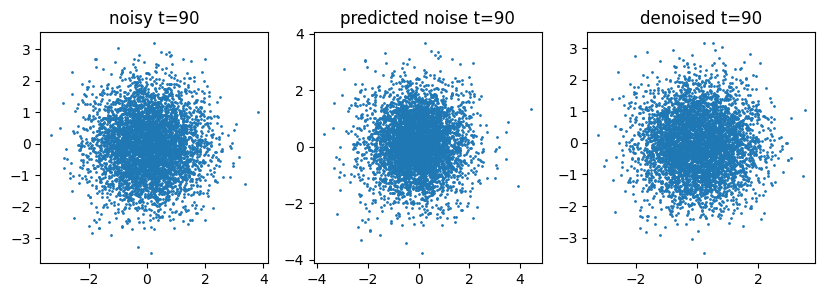

In [59]:
rows.keys()
t=90

noisy, pred_noise, denoised = rows[t]

plt.figure(figsize=(10, 3)) 

plt.subplot(1, 3, 1) 
plt.scatter(noisy[:, 0].cpu().numpy(), noisy[:, 1].cpu().numpy(), s=1)
plt.title(f'noisy t={t}')
plt.subplot(1, 3, 2)
plt.scatter(pred_noise[:, 0].cpu().numpy(), pred_noise[:, 1].cpu().numpy(), s=1)
plt.title(f'predicted noise t={t}')
plt.subplot(1, 3, 3)
plt.scatter(denoised[:, 0].cpu().numpy(), denoised[:, 1].cpu().numpy(), s=1)
plt.title(f'denoised t={t}')
plt.show()
